### Load Libraries

In [1]:
import numpy as np
import os, re
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report

### Files directory

In [2]:
root_path = '/home/itachi/Natural_language_processing/data/BBC_data'
#top_view folders
folders = [root_path + '/' + folder + '/' for folder in os.listdir(root_path)]


#there are only 5 classes
class_titles = os.listdir(root_path)


#list of all the files belonging to each class
files = {}
for folder, title in zip(folders, class_titles):
    files[title] = [folder + f for f in os.listdir(folder)]

In [3]:
print folders[:5]
print "-"*100
print class_titles[:]
print "-"*100
print files['politics'][:5]

['/home/itachi/Natural_language_processing/data/BBC_data/politics/', '/home/itachi/Natural_language_processing/data/BBC_data/sport/', '/home/itachi/Natural_language_processing/data/BBC_data/tech/', '/home/itachi/Natural_language_processing/data/BBC_data/entertainment/', '/home/itachi/Natural_language_processing/data/BBC_data/business/']
----------------------------------------------------------------------------------------------------
['politics', 'sport', 'tech', 'entertainment', 'business']
----------------------------------------------------------------------------------------------------
['/home/itachi/Natural_language_processing/data/BBC_data/politics/230.txt', '/home/itachi/Natural_language_processing/data/BBC_data/politics/348.txt', '/home/itachi/Natural_language_processing/data/BBC_data/politics/094.txt', '/home/itachi/Natural_language_processing/data/BBC_data/politics/154.txt', '/home/itachi/Natural_language_processing/data/BBC_data/politics/286.txt']


### Split documents to test and train sets

In [4]:
train_test_ratio = 0.75

def train_test_split(ratio, classes, files):
    """
    this method will split the input list of files to train and test sets.

    Parameters:

    ratio: ratio of total documents in each class assigned to the training set 
    
    classes: list of label classes
    
    files: a dictionary with list of files for each class
    """
    # a dictionary with lists of documents in the training set for each class
    train_dict = {}
    
    # a dictionary with lists of documents in the testing set for each class
    test_dict = {}  
    
    for cl in classes:
        train_cnt = int(ratio * len(files[cl]))
        train_dict[cl] = files[cl][:train_cnt]
        test_dict[cl] = files[cl][train_cnt:]
    return train_dict, test_dict

In [5]:
train_path, test_path = train_test_split(train_test_ratio, class_titles, files)

### Cleanup text

In [6]:
pattern = re.compile(r'([a-zA-Z]+|[0-9]+(\.[0-9]+)?)')

def cleanupText(path):
    """
    this method will read in a text file and try to cleanup its text.
    
    Parameters:
    
    path: (str) path to the document file
    
    Returns:
    
    text_translated: (str) cleaned up version of the raw text in the input file
    """
    from string import punctuation, digits
    text_translated = ''
    try:
        f = open(path)
        raw = f.read().lower()
        text = pattern.sub(r' \1 ', raw.replace('\n', ' '))
        text_translated = text.translate(None, punctuation + digits)
        text_translated = ' '.join([word for word in text_translated.split(' ') if (word and len(word) > 1)])
    finally:
        f.close()
    return text_translated


### Create arrays of documents and their corresponding labels

In [7]:
train_arr = []
test_arr = []
train_lbl = []
test_lbl = []
for cl in class_titles:
    for path in train_path[cl]:
        train_arr.append(cleanupText(path))
        train_lbl.append(cl)
    for path in test_path[cl]:
        test_arr.append(cleanupText(path))
        test_lbl.append(cl)
        
# print 50 characters of the first article in training array       
print train_arr[0][:50]
print "-"*100
print "Articles in test data :",len(test_arr)

burglar defence guidelines issued householders who
----------------------------------------------------------------------------------------------------
Articles in test data : 559


### Create text vectorizer

In [8]:
vectorizer = CountVectorizer()
vectorizer.fit(train_arr)
train_mat = vectorizer.transform(train_arr)
test_mat = vectorizer.transform(test_arr)
print train_mat.shape
print test_mat.shape

(1666, 24854)
(559, 24854)


### Create Tfidf Transformer

In [9]:
tfidf = TfidfTransformer()
tfidf.fit(train_mat)
train_tfmat = tfidf.transform(train_mat)
test_tfmat = tfidf.transform(test_mat)
print train_tfmat.shape
print test_tfmat.shape

(1666, 24854)
(559, 24854)


### Test Classifier

In [10]:
def testClassifier(x_train, y_train, x_test, y_test, clf):
    """
    this method will first train the classifier on the training data
    and will then test the trained classifier on test data.
    Finally it will report some metrics on the classifier performance.
    
    Parameters:
    
    x_train: (np.ndarray) train data matrix
    
    y_train: (list) train data label
    
    x_test: (np.ndarray) test data matrix
    
    y_test: (list) test data label
    
    clf: sklearn classifier object implementing fit() and predict() methods
    
    Returns:

    metrics: list
             [training time, testing time, recall and precision for every class, macro-averaged F1 score]
    """
    metrics = []
    start = dt.now()
    clf.fit(x_train, y_train)
    end = dt.now()
    print 'training time: ', (end - start)
    
    # add training time to metrics
    metrics.append(end-start)
    
    start = dt.now()
    pred = clf.predict(x_test)
    end = dt.now()
    print 'testing time: ', (end - start)
    
    # add testing time to metrics
    metrics.append(end-start)
    
    print 'classification report: '
    # print classification_report(y_test, yhat)
    print (classification_report(y_test, pred))
    
    print 'f1 score'
    print f1_score(y_test, pred, average='macro')
    
    print 'accuracy score'
    print accuracy_score(y_test, pred)
    
    precision = precision_score(y_test, pred, average=None)
    recall = recall_score(y_test, pred, average=None)
    
    # add precision and recall values to metrics
    for p, r in zip(precision, recall):
        metrics.append(p)
        metrics.append(r)
    
    
    #add macro-averaged F1 score to metrics
    metrics.append(f1_score(y_test, pred, average='macro'))
    
    print 'confusion matrix:'
    print confusion_matrix(y_test, pred)
    
    # plotting the confusion matrix
    plt.imshow(confusion_matrix(y_test, pred), interpolation='nearest')
    plt.show()
    
    return metrics

### Train classifier

/home/itachi/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


training time:  0:05:17.493478
testing time:  0:00:00.477151
classification report: 
               precision    recall  f1-score   support

     business       0.95      0.92      0.94       128
entertainment       0.95      0.98      0.96        97
     politics       0.94      0.95      0.95       105
        sport       0.97      0.99      0.98       128
         tech       0.96      0.93      0.94       101

  avg / total       0.96      0.96      0.96       559

f1 score
0.95485216779
accuracy score
0.955277280859
confusion matrix:
[[118   1   4   2   3]
 [  1  95   1   0   0]
 [  2   0 100   2   1]
 [  1   0   0 127   0]
 [  2   4   1   0  94]]


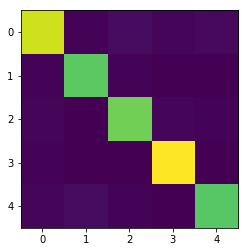

In [11]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, objective='binary:logistic',
                    nthread=-1, gamma=0, min_child_weight=1, subsample=1, colsample_bytree=1,
                    scale_pos_weight=1, seed=0,)
xgb_boost = testClassifier(train_tfmat.toarray(), train_lbl, test_tfmat.toarray(), test_lbl, xgb)

training time:  0:00:42.369388
testing time:  0:00:00.123052
classification report: 
               precision    recall  f1-score   support

     business       0.98      0.95      0.97       128
entertainment       1.00      0.97      0.98        97
     politics       0.94      0.99      0.96       105
        sport       1.00      1.00      1.00       128
         tech       0.97      0.98      0.98       101

  avg / total       0.98      0.98      0.98       559

f1 score
0.978175916612
accuracy score
0.978533094812
confusion matrix:
[[122   0   3   0   3]
 [  0  94   3   0   0]
 [  1   0 104   0   0]
 [  0   0   0 128   0]
 [  1   0   1   0  99]]


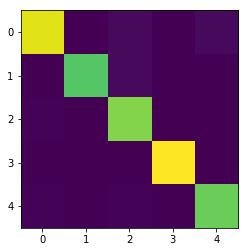

In [12]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(40,40,40))
# If we tune we can get more accuracy
neural_net = testClassifier(train_tfmat.toarray(), train_lbl, test_tfmat.toarray(), test_lbl, mlp)

training time:  0:02:42.464283
testing time:  0:00:00.052225
classification report: 
               precision    recall  f1-score   support

     business       0.91      0.91      0.91       128
entertainment       0.95      0.95      0.95        97
     politics       0.93      0.95      0.94       105
        sport       0.98      0.98      0.98       128
         tech       0.93      0.92      0.93       101

  avg / total       0.94      0.94      0.94       559

f1 score
0.942335525171
accuracy score
0.942754919499
confusion matrix:
[[117   1   3   2   5]
 [  3  92   1   0   1]
 [  4   0 100   0   1]
 [  1   0   2 125   0]
 [  3   4   1   0  93]]


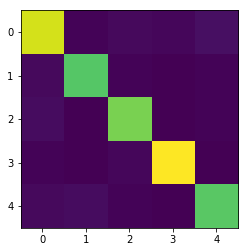

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(n_estimators=20, learning_rate=.1,
                                max_depth=4, random_state=0, subsample=0.8, max_features=0.5)
gbm_boost = testClassifier(train_tfmat.toarray(), train_lbl, test_tfmat.toarray(), test_lbl, gbm)

training time:  0:01:14.306085
testing time:  0:00:00.204210
classification report: 
               precision    recall  f1-score   support

     business       0.77      0.83      0.80       128
entertainment       0.80      0.89      0.84        97
     politics       0.87      0.80      0.83       105
        sport       0.97      0.94      0.95       128
         tech       0.94      0.87      0.90       101

  avg / total       0.87      0.87      0.87       559

f1 score
0.865953095633
accuracy score
0.865831842576
confusion matrix:
[[106   8   8   1   5]
 [  6  86   4   1   0]
 [ 11   7  84   2   1]
 [  5   2   1 120   0]
 [  9   4   0   0  88]]


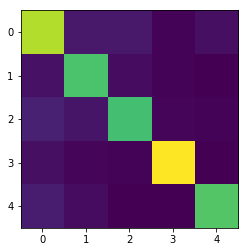

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), n_estimators=20, 
                         learning_rate=.1, algorithm="SAMME.R", random_state=100)
ada_boost = testClassifier(train_tfmat.toarray(), train_lbl, test_tfmat.toarray(), test_lbl, ada)